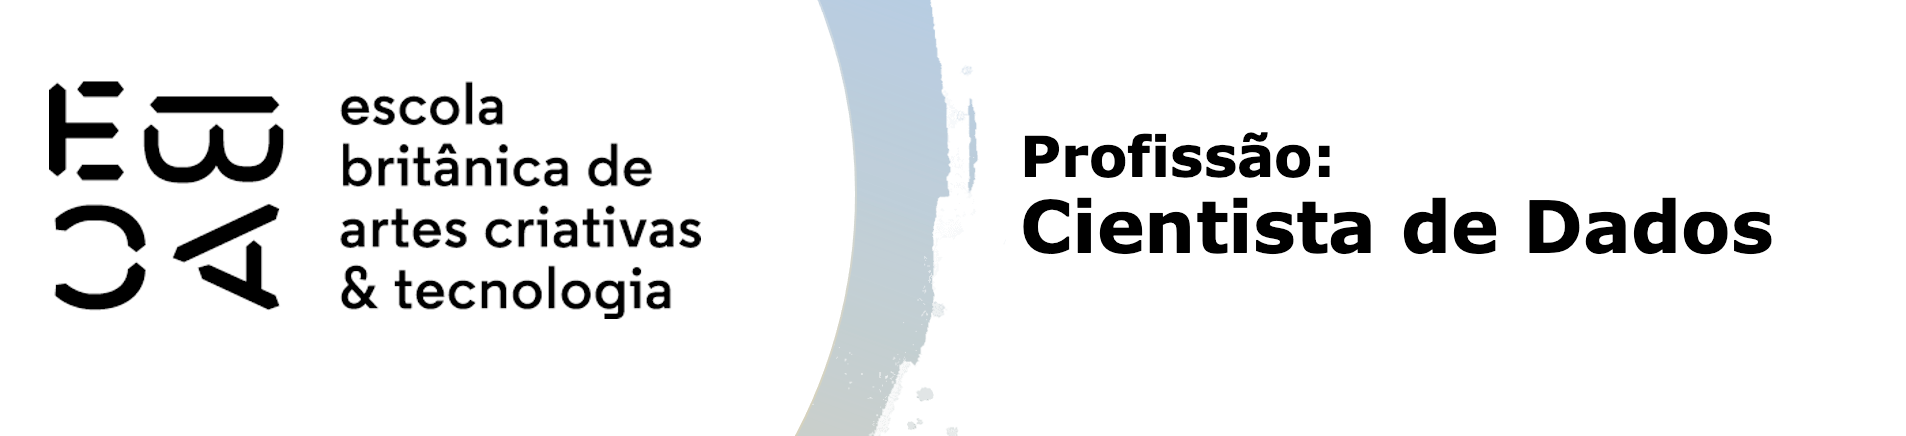

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Carregando Dados

In [142]:
df_original = pd.read_csv('previsao_de_renda_II.csv')
df_original

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
749996,2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37
749997,2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
749998,2016-03-01,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


### Verificando Missing
### Criando df_modelado
### Trocando missing do tempo_emprego pela média

In [143]:
# Verificando valores faltantes
df_original.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [144]:
# Criando novo DataFrame para fazer algumas modificações e deixar o original separado
df_modelado = df_original.copy()

# Substituindo os valores faltantes pela média
df_modelado['tempo_emprego'].fillna(df_modelado['tempo_emprego'].mean(), inplace = True)
df_modelado.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Transformando data_ref em tipo data para separar treino e teste pelas datas

In [145]:
# Transformando o data_ref no tipo data para poder trabalhar melhor com essa coluna
df_modelado['data_ref'] = pd.to_datetime(df_modelado['data_ref'])
df_modelado['data_ref'].dtypes

dtype('<M8[ns]')

### Verificando tipo dos dados
### Separando colunas do tipo object
### Aplicando one hot encoding

In [146]:
# Verificando o tipos dos dados
df_modelado.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
dtype: object

In [147]:
# Separando as colunas categóricas para aplicar o one-hot encoding apenas nessas variáveis
categoricas = df_modelado.select_dtypes(include = ['object']).columns
categoricas

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

In [148]:
# Transformando em dummy as colunas do tipo object
# Deixei sem o drop first pra não confundir na analise, mas se tiver necessidade isso pode ser alterado
df_modelado = pd.get_dummies(df_modelado, columns=categoricas, drop_first=True)
df_modelado

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,2015-01-01,5762,0,47,16.717808,2.0,11138.14,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2015-01-01,1279,0,30,9.600000,2.0,2424.81,1,1,0,...,1,0,0,0,0,1,0,0,0,0
2,2015-01-01,14111,0,28,8.208219,2.0,13749.66,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2015-01-01,8189,2,44,1.301370,4.0,2361.84,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,2015-01-01,1830,2,33,1.254795,4.0,790.78,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,11611,1,29,8.665753,3.0,2930.40,0,0,1,...,0,0,0,0,0,1,0,0,0,0
749996,2016-03-01,9144,0,65,7.746165,2.0,4084.37,0,0,1,...,0,0,0,0,0,1,0,0,0,0
749997,2016-03-01,16583,0,33,10.969863,2.0,4339.66,0,0,1,...,0,0,0,0,0,1,0,0,0,0
749998,2016-03-01,3024,1,28,8.219178,3.0,9159.49,0,1,1,...,0,0,0,1,0,1,0,0,0,0


### Separando em treino e teste usando os ultimos 3 meses para teste e o resto para treino e removendo as colunas data_ref e index

In [149]:
# Guardando valor da ultima data
ultima_data = df_modelado['data_ref'].max()

# Criando novo DataFrame de teste contendo apenas os ultimos 3 meses em teste
# Criando novo DataFrame de treino contendo todas datas menos os ultimos 3 meses
# Esses DFs vão conter a variável resposta ainda
df_teste_total = df_modelado[df_modelado['data_ref'] >= ultima_data - pd.DateOffset(months=3)]
df_treino_total = df_modelado[df_modelado['data_ref'] < ultima_data - pd.DateOffset(months=3)]

# DFs para se necessário usar a data e index
df_teste_data = df_teste_total.copy()
df_treino_data = df_treino_total.copy()

# DFs padrões de treino e teste
df_treino = df_treino_total.copy()
df_teste = df_teste_total.copy()

# Removendo as colunas data_ref e index
df_teste.drop(columns=['data_ref', 'index'], inplace=True)
df_treino.drop(columns=['data_ref', 'index'], inplace=True)
df_teste_total.drop(columns=['data_ref', 'index'], inplace=True)
df_treino_total.drop(columns=['data_ref', 'index'], inplace=True)

# Separarando a variável de resposta dos dados de treinamento e teste
y_treino = df_treino['renda']
y_treino_log = np.log(y_treino)
y_teste = df_teste['renda']
y_teste_log = np.log(y_teste)

# Remover a variável de resposta dos dados de treinamento e teste
df_treino = df_treino.drop(columns=['renda'])
df_teste = df_teste.drop(columns=['renda'])

C:\Users\Bill_\AppData\Local\Temp\ipykernel_8760\1395548104.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste_total.drop(columns=['data_ref', 'index'], inplace=True)
C:\Users\Bill_\AppData\Local\Temp\ipykernel_8760\1395548104.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treino_total.drop(columns=['data_ref', 'index'], inplace=True)


In [150]:
# Proporção dos dados
prop_treino = (df_treino.shape[0]/df_modelado.shape[0])
prop_teste = (df_teste.shape[0]/df_modelado.shape[0])

print(f'Proporção de dados para TREINO: {prop_treino}')
print(f'Proporção de dados para TESTE: {prop_teste}')


Proporção de dados para TREINO: 0.7333333333333333
Proporção de dados para TESTE: 0.26666666666666666


### Modelo simples apenas para fim de comparação

In [151]:
# Criado o modelo de regressão
modelo = sm.OLS(y_treino, sm.add_constant(df_treino))

# Ajuste do modelo aos dados
reg = modelo.fit()

# Salvando as predições feitas em y_pred
y_pred = reg.predict(sm.add_constant(df_treino))


print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     7711.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:49:39   Log-Likelihood:            -7.0524e+06
No. Observations:              550000   AIC:                         1.410e+07
Df Residuals:                  549975   BIC:                         1.411e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

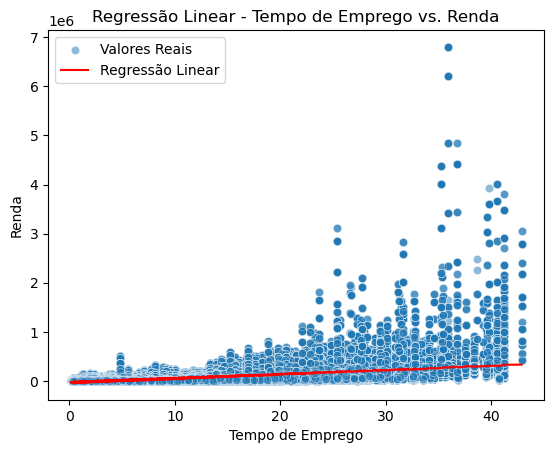

In [152]:
# Criado um DataFrame com os dados
df_plot = pd.DataFrame({'tempo_emprego': df_treino['tempo_emprego'], 'y_treino': y_treino, 'y_pred': y_pred})

# Gráfico com seaborn
sns.scatterplot(x='tempo_emprego', y='y_treino', data=df_plot, alpha=0.5, label='Valores Reais')
sns.lineplot(x='tempo_emprego', y='y_pred', data=df_plot, color='red', label='Regressão Linear')

plt.xlabel("Tempo de Emprego")
plt.ylabel("Renda")
plt.title("Regressão Linear - Tempo de Emprego vs. Renda")
plt.legend()
plt.show()

### Resultado na escala logaritimica

In [153]:
# Criando o modelo de regressão com a variável de resposta em log
modelo_log = sm.OLS(y_treino_log, sm.add_constant(df_treino))

# Ajustando o modelo aos dados
reg_log = modelo_log.fit()

# Calculando as previsões do modelo para os dados de treinamento
y_pred_log = reg_log.predict(sm.add_constant(df_treino))


print(reg_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                 1.828e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:51:30   Log-Likelihood:            -7.2534e+05
No. Observations:              550000   AIC:                         1.451e+06
Df Residuals:                  549975   BIC:                         1.451e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

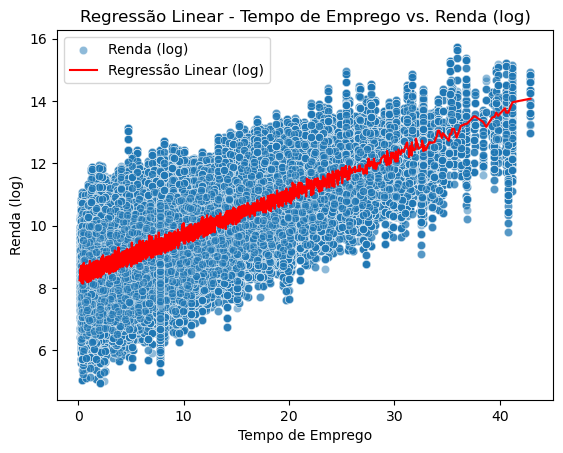

In [154]:
# Criando um DataFrame com os dados em log
df_plot_log = pd.DataFrame({'tempo_emprego': df_treino['tempo_emprego'], 'y_treino_log': y_treino_log, 'y_pred_log': y_pred_log})

# Gráfico com seaborn
sns.scatterplot(x='tempo_emprego', y='y_treino_log', data=df_plot_log, alpha=0.5, label='Renda (log)')
sns.lineplot(x='tempo_emprego', y='y_pred_log', data=df_plot_log, color='red', label='Regressão Linear (log)')

plt.xlabel("Tempo de Emprego")
plt.ylabel("Renda (log)")
plt.title("Regressão Linear - Tempo de Emprego vs. Renda (log)")
plt.legend()
plt.show()

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

### Verificando se possui distribuição normal

#### Sim, a distribuição está em formato de "sino", sendo uuma distribuição normal

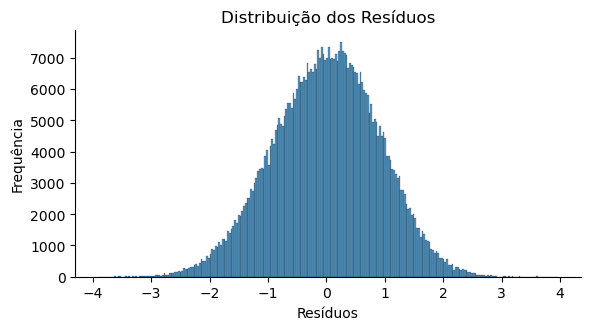

In [155]:
# Calcular os resíduos
residuos = reg_log.resid

# Plotar a distribuição dos resíduos
sns.displot(residuos, height=3, aspect=2)
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos")
plt.show()

### Verificando a distribuição dos resíduos e sua independência

#### Verifiquei com todos os dados e com 15000 dos dados escolhidos randomicamente e salvo na "semente" 42, fiz isso porque usar todos os dados estava levando muito tempo de execução e o resultado foi semelhante, além de dar para ver melhor os dados.
<br>

#### Qualquer coisa a execução para todos os dados está comentada abaixo ou a quantidade de valores podem ser aumentados.

In [156]:
'''# Plotar o gráfico de resíduos com a linha do Lowess
sns.residplot(x=reg_log.fittedvalues, y=residuos, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs. Valores Ajustados com Lowess")
plt.show()'''

'# Plotar o gráfico de resíduos com a linha do Lowess\nsns.residplot(x=reg_log.fittedvalues, y=residuos, lowess=True, line_kws={\'color\': \'red\'})\nplt.xlabel("Valores Ajustados")\nplt.ylabel("Resíduos")\nplt.title("Gráfico de Resíduos vs. Valores Ajustados com Lowess")\nplt.show()'

#### De acordo com o gráfico apresentado, a curva do lowess apresenta um leve declinio para os valores negativos, porém sem nenhuma caracteristica muito marcante e os dados tem uma variância bem aleatória e aumentando, levando a supor que os residuos tem sim independência e não estão co-relacionados.

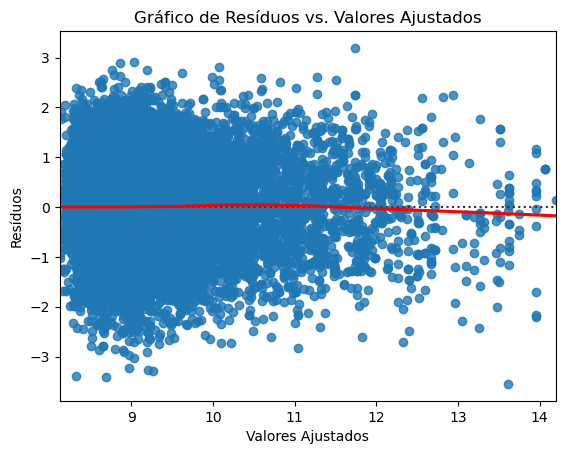

In [157]:
# Definir semente para reprodução
random.seed(42)

# Selecionar aleatoriamente 1000 índices dos valores ajustados
sample_indices = random.sample(range(len(reg_log.fittedvalues)), 15000)

# Obter os valores ajustados e os resíduos correspondentes para a amostra
fitted_values_sampled = reg_log.fittedvalues.iloc[sample_indices]
residuos_sampled = residuos.iloc[sample_indices]

# Plotar o gráfico de resíduos com uma amostra dos dados e com Lowess desativado
sns.residplot(x=fitted_values_sampled, y=residuos_sampled, lowess=True, line_kws={'color': 'red'})

# Adicionar rótulos e título ao gráfico
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs. Valores Ajustados")

# Exibir o gráfico
plt.show()

In [158]:
# Verificando as variáveis explicativas que vão ser percorridas no looping a baixo para gerar os gráficos
explicativas = df_treino.columns
explicativas

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Médio', 'educacao_Pós graduação',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental'],
      dtype='object')

#### As variáveis numéricas tem suas peculiaridades, geralmente apresentam menor variabilidade em seus valores extremos ou alguma noção de outliers, mas nada fora do comum ou conclusivo. As variáveis categóricas ficaram um pouco dificeis de se tirar conclusões, em alguns casos foi possível ver uma menor variância dos resultados, mas vai ter uma nova sequencia de gráficos apenas para esse tipo de dado logo abaixo.

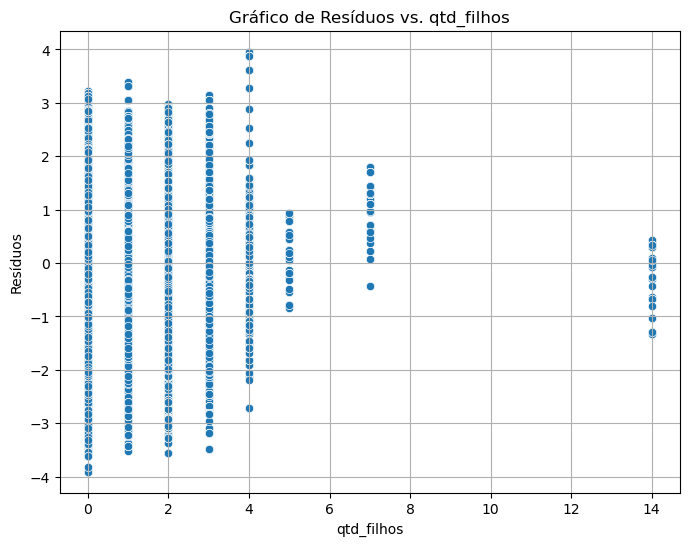

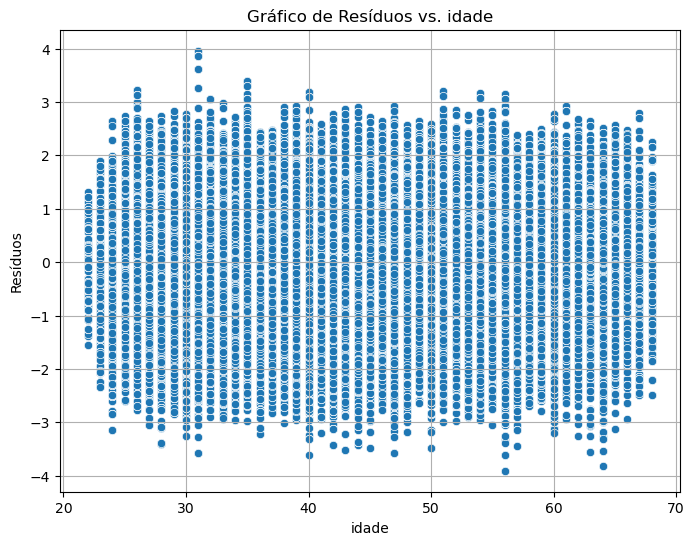

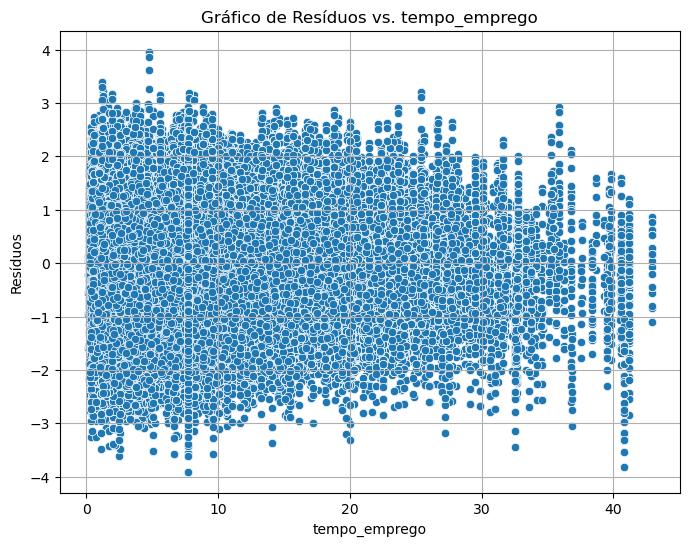

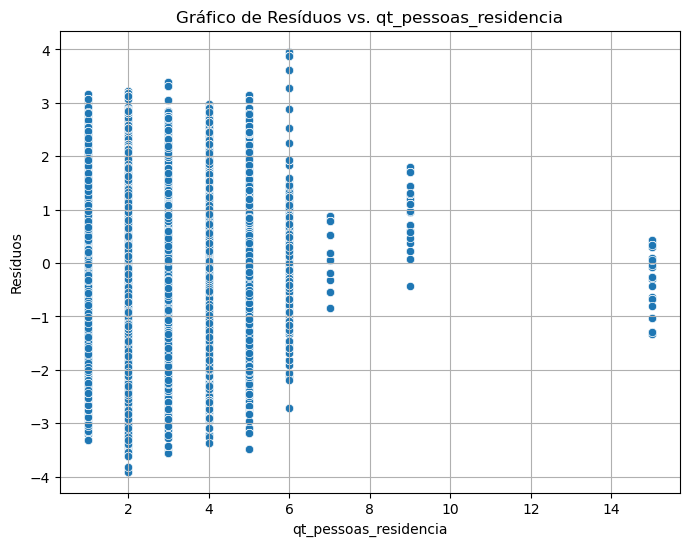

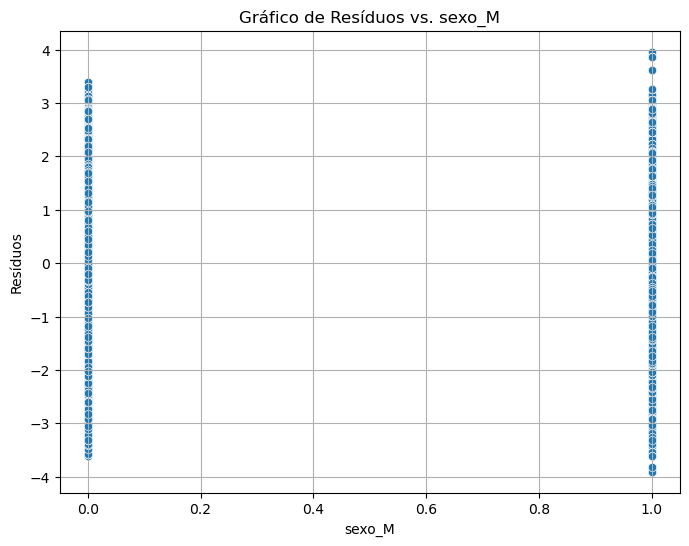

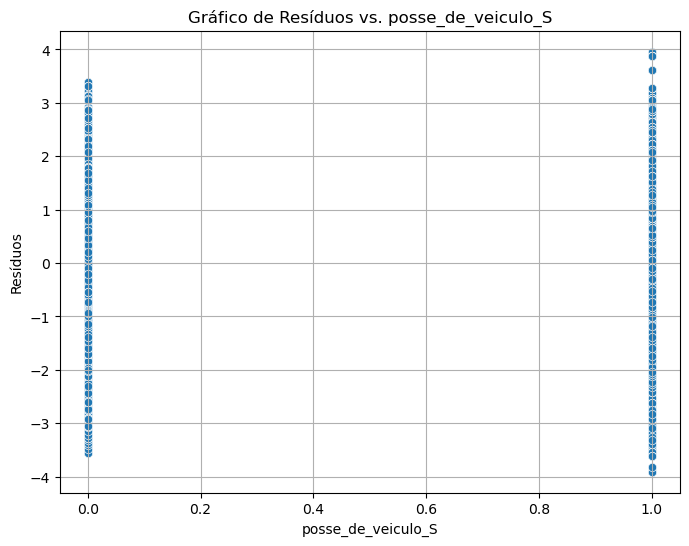

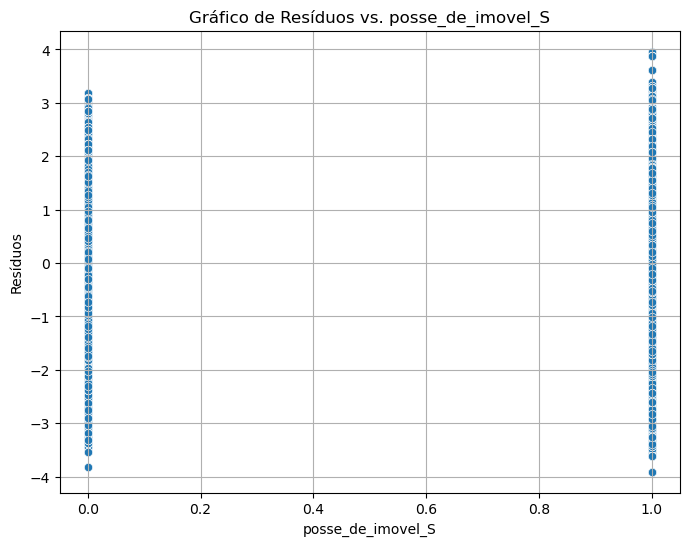

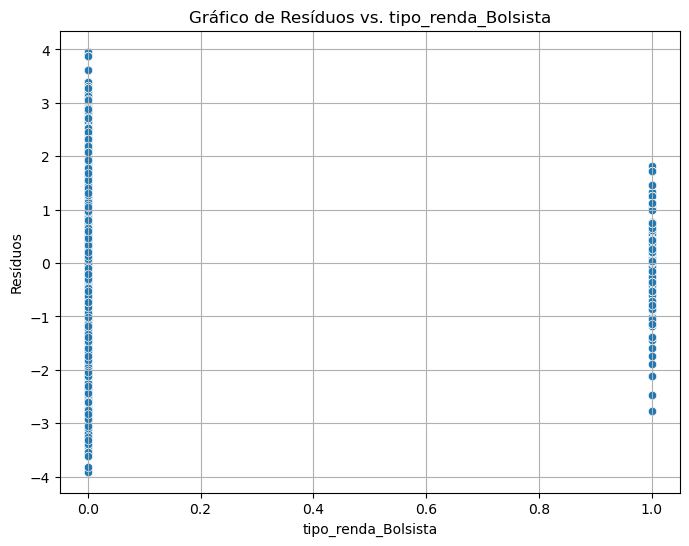

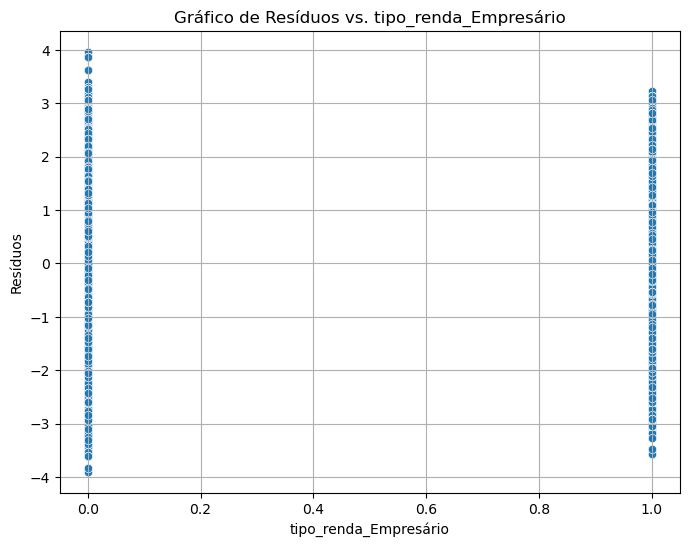

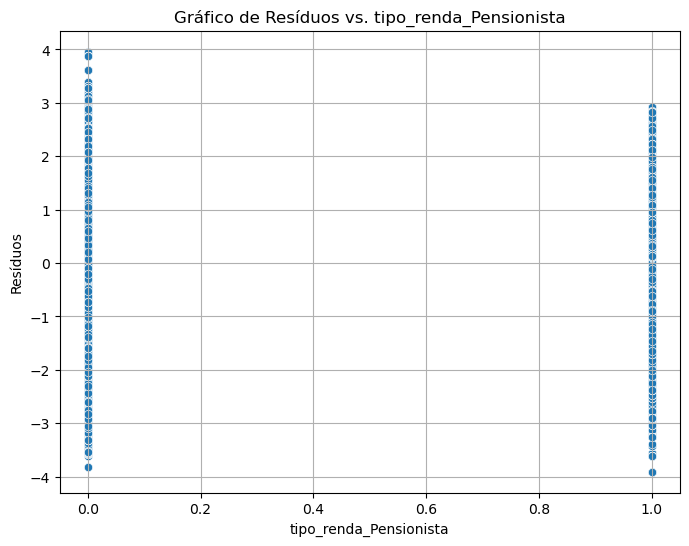

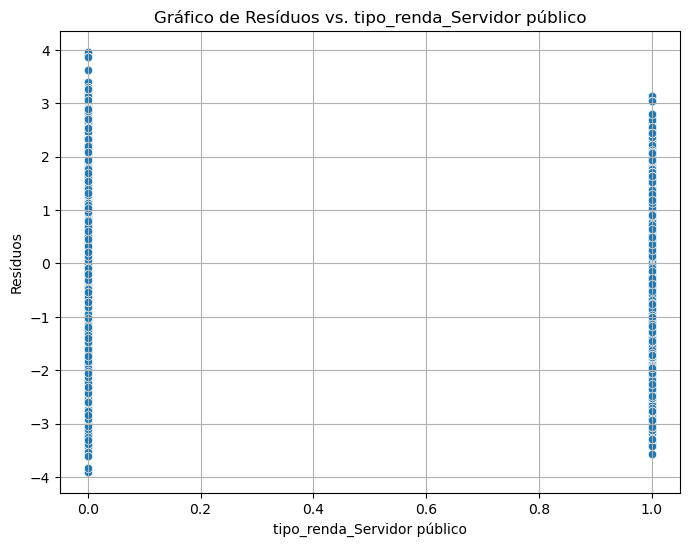

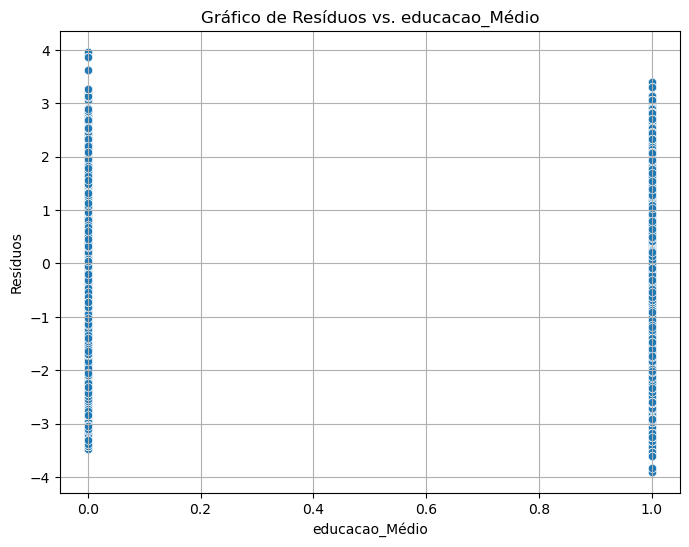

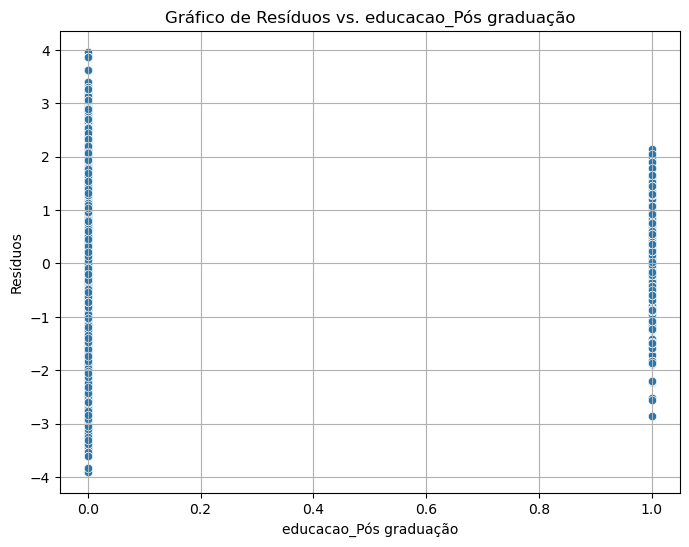

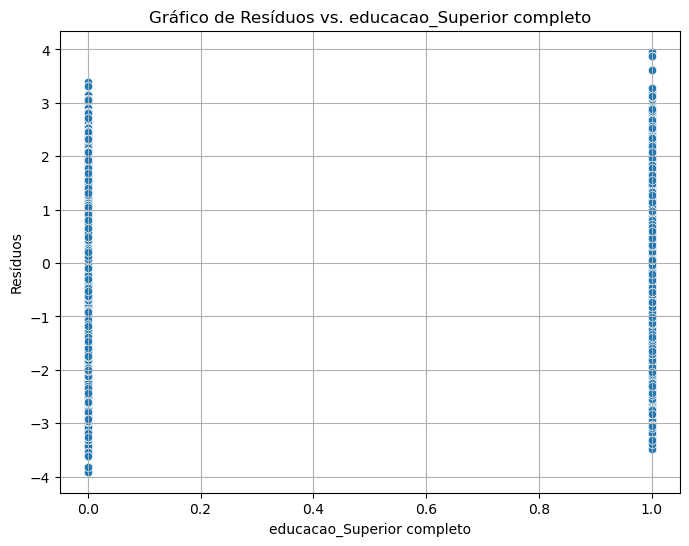

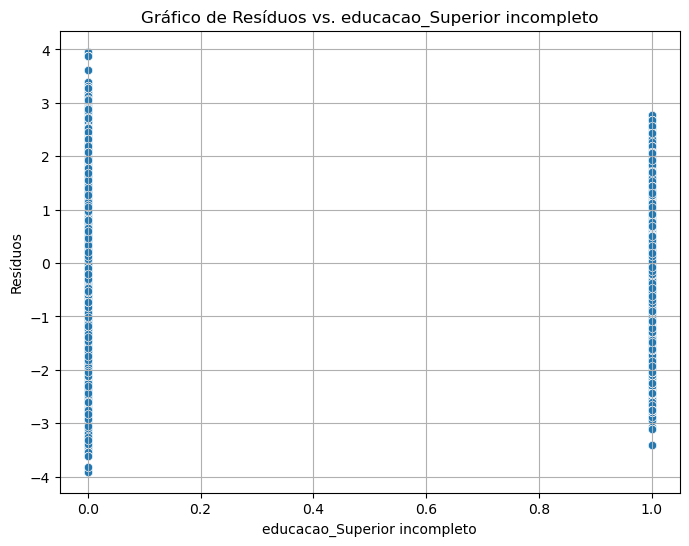

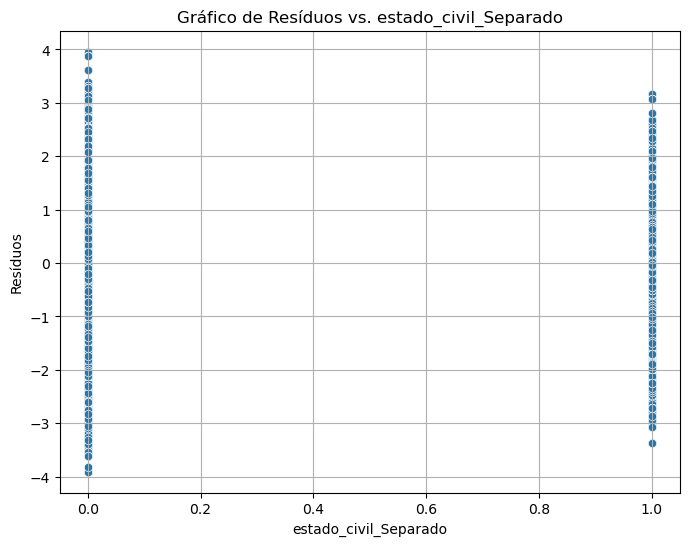

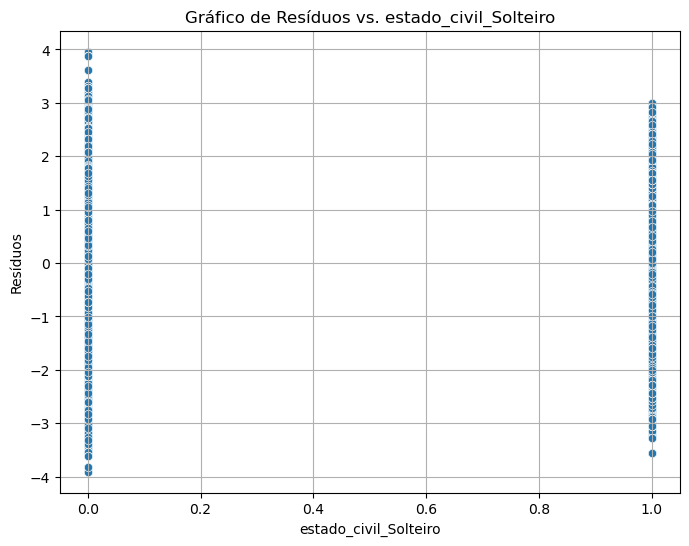

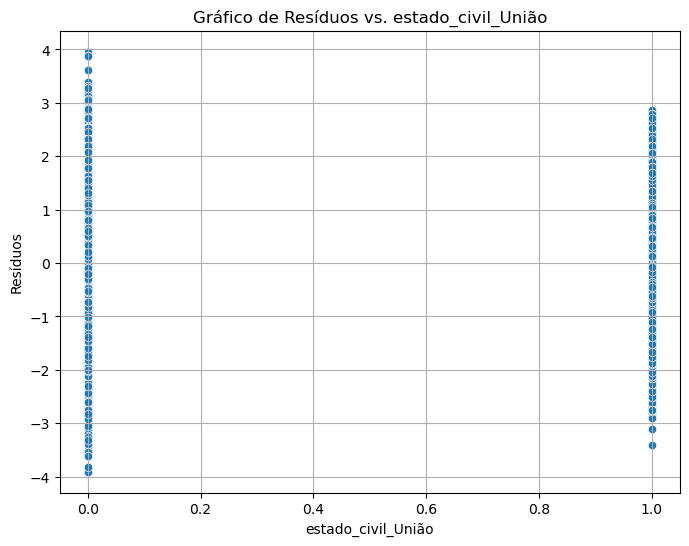

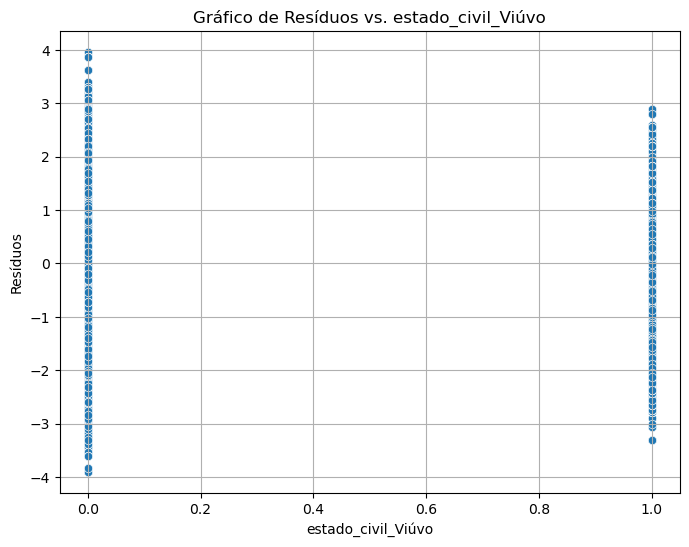

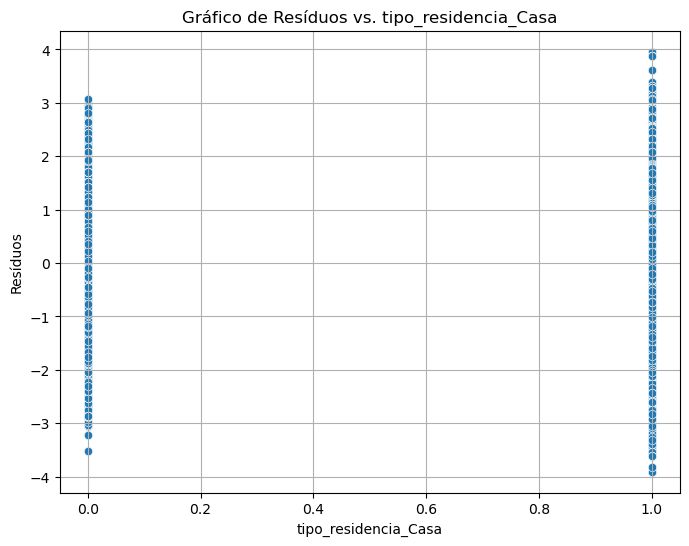

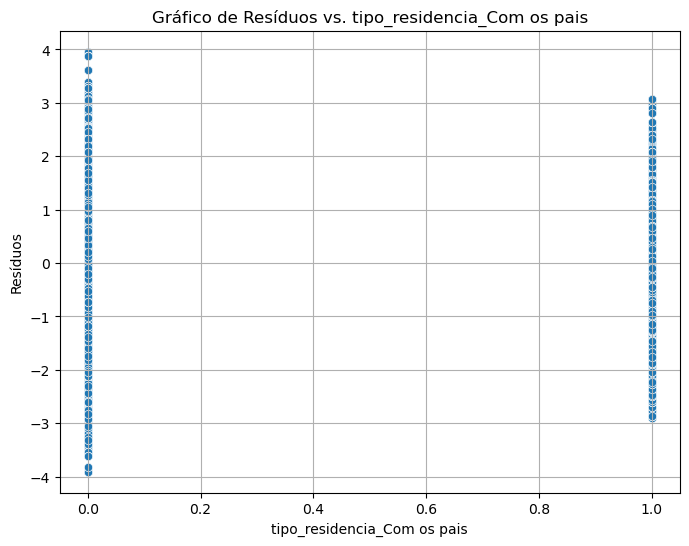

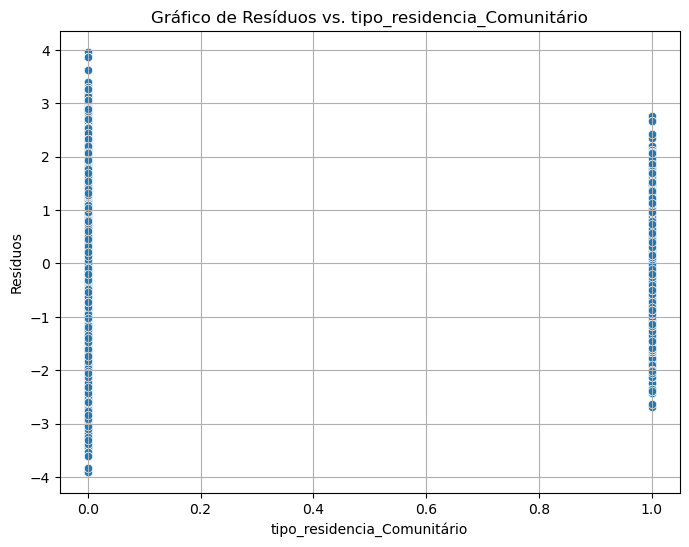

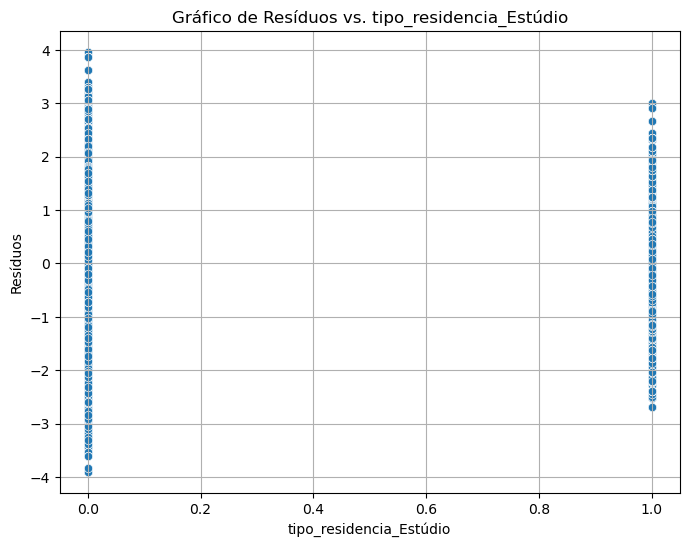

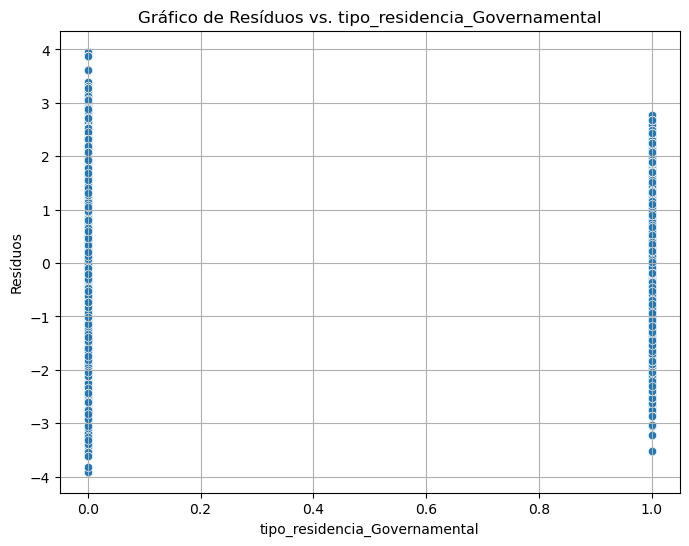

In [159]:
for explicativa in explicativas:
    # Plotar o gráfico de dispersão dos resíduos vs a variável explicativa escolhida
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_treino[explicativa], y=residuos)
    plt.xlabel(explicativa)
    plt.ylabel("Resíduos")
    plt.title(f"Gráfico de Resíduos vs. {explicativa}")
    plt.grid(True)
    plt.show()

#### Resolvi fazer mais um punhado de gráficos apenas com as categóricas, agora usando a média para verificar se é possível tirar melhores conclusões, deu apenas para perceber que em geral o modelo erra para valores maiores, o que resulta em residuos negativos.

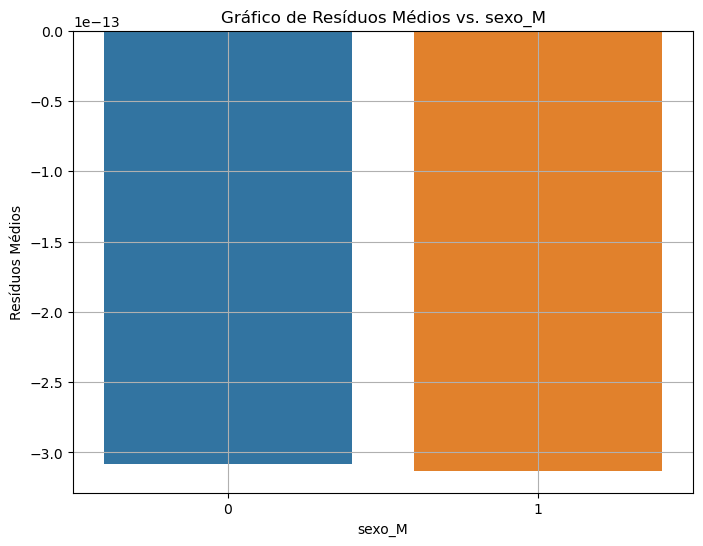

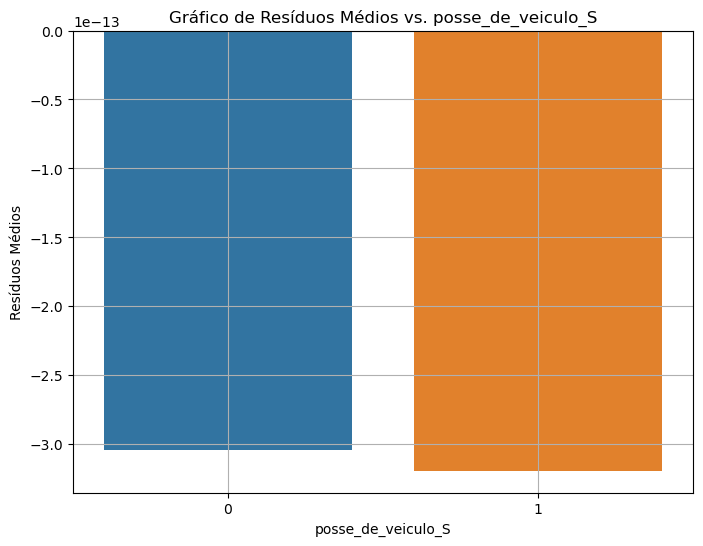

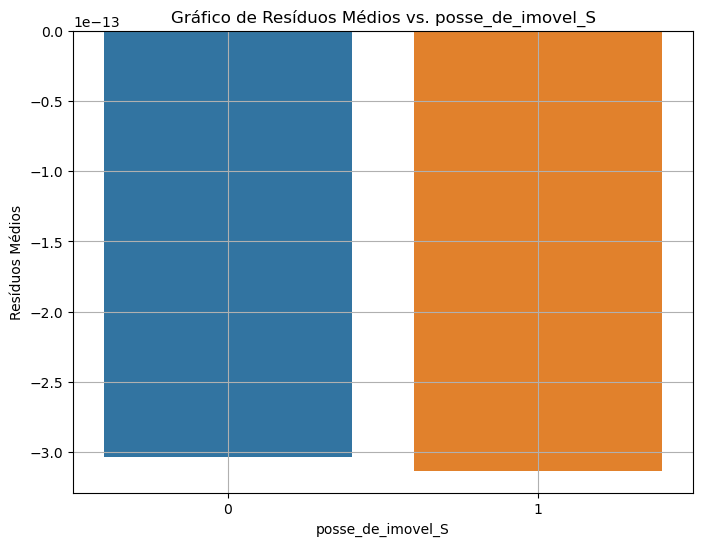

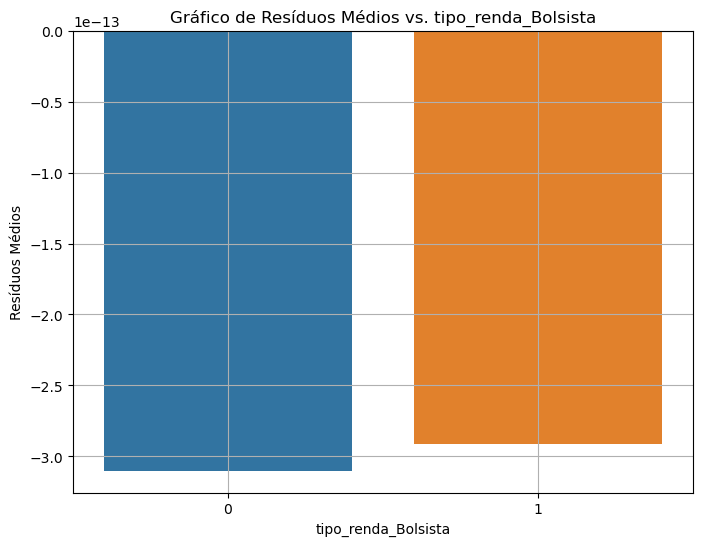

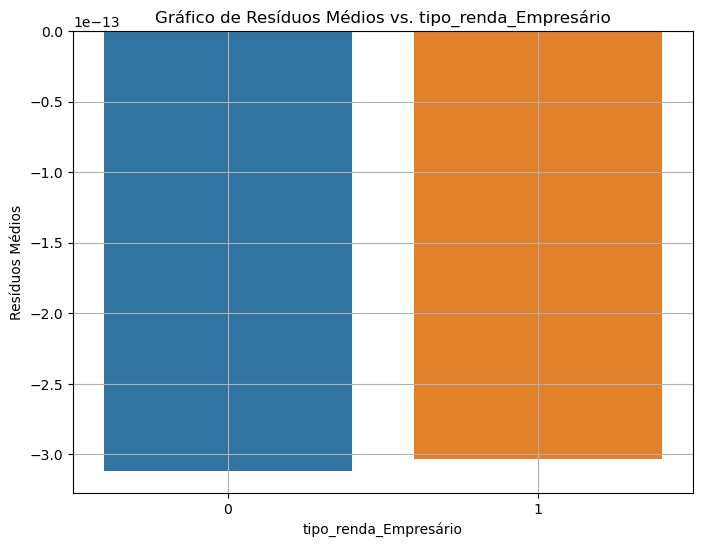

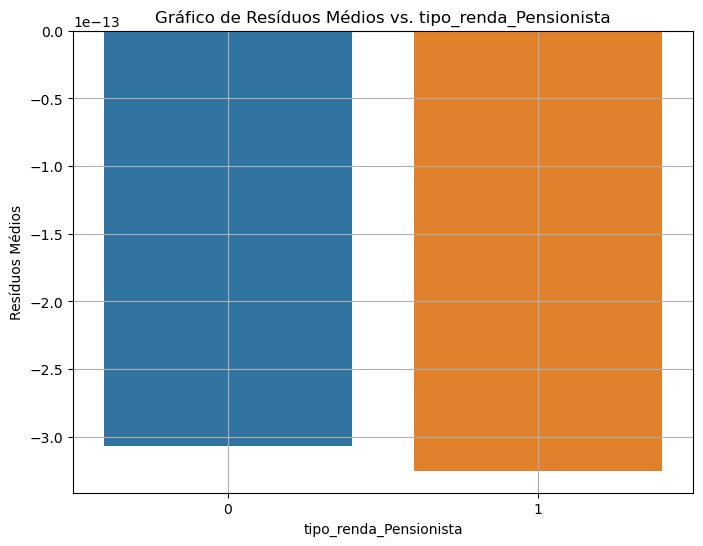

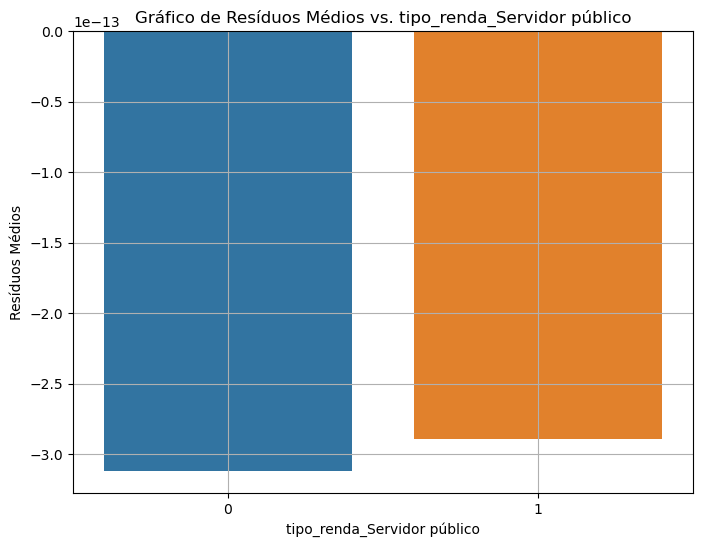

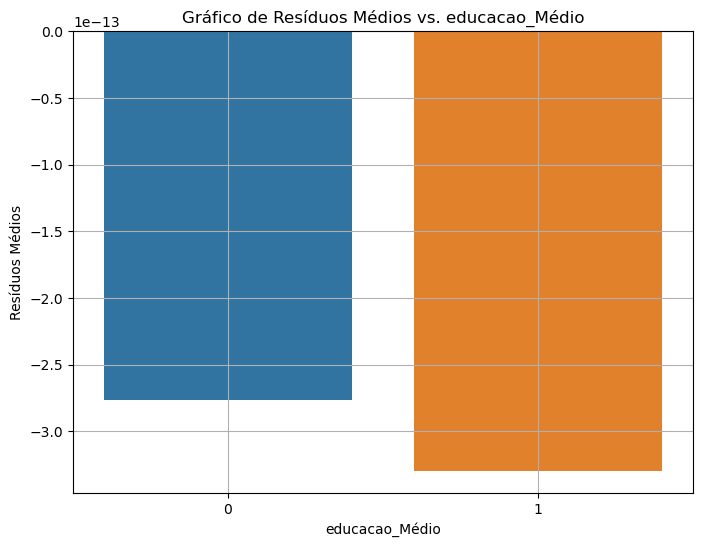

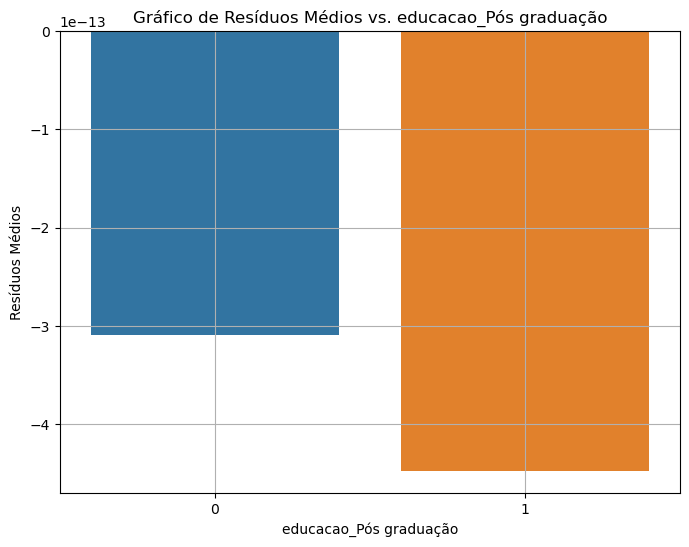

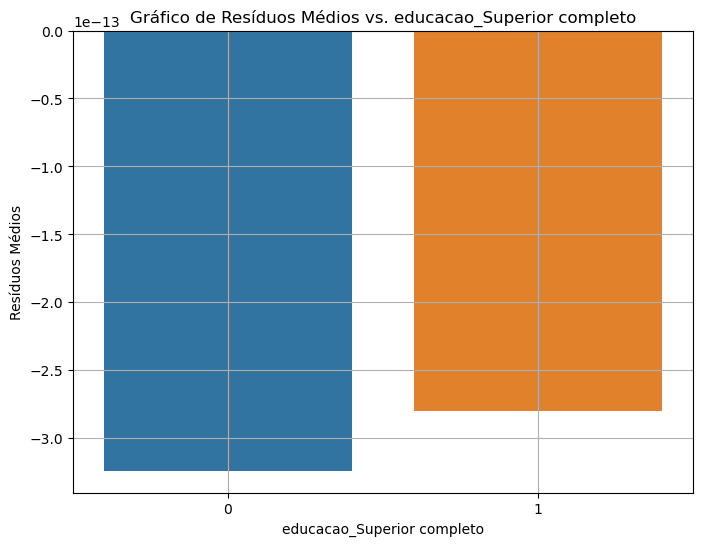

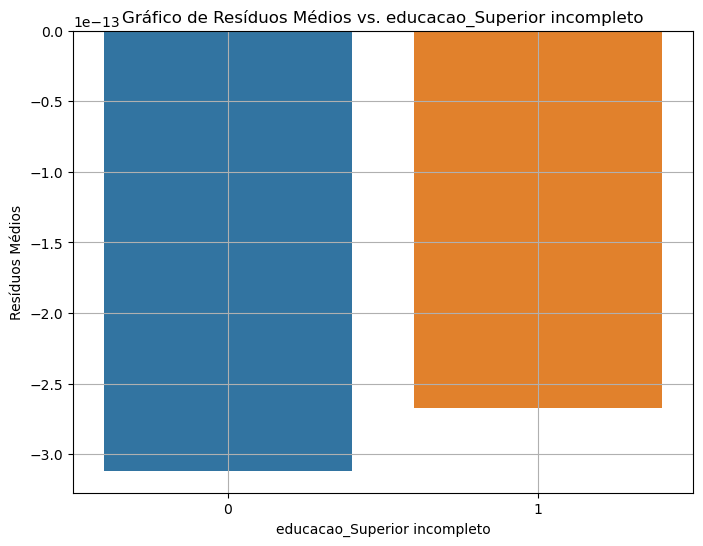

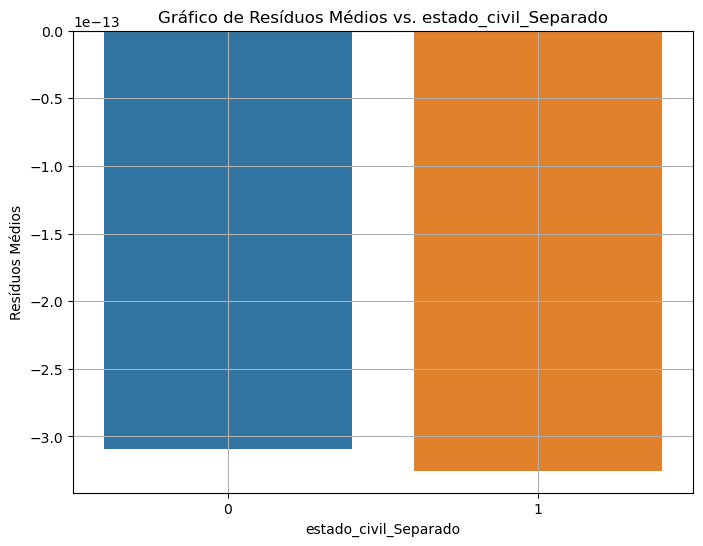

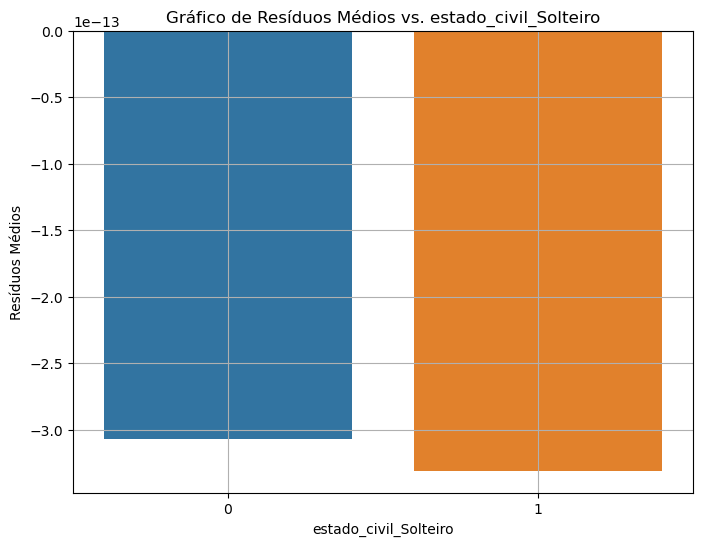

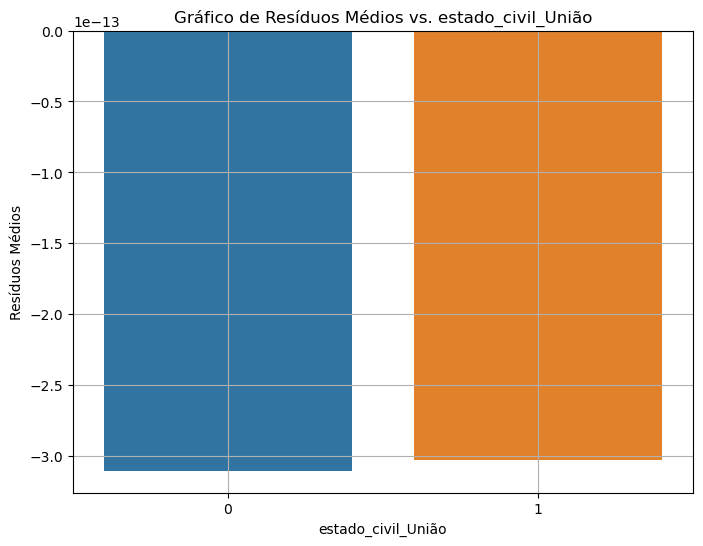

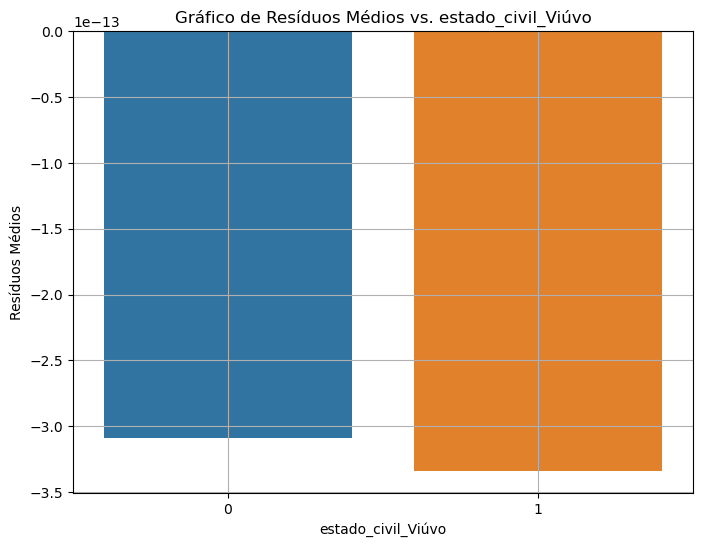

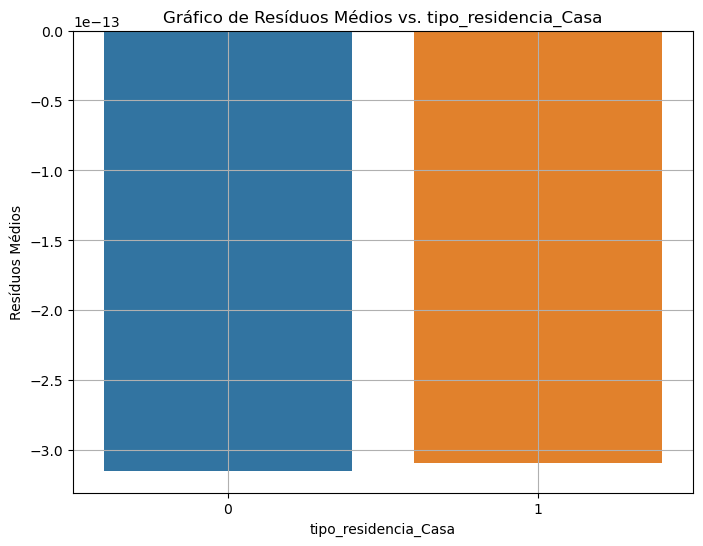

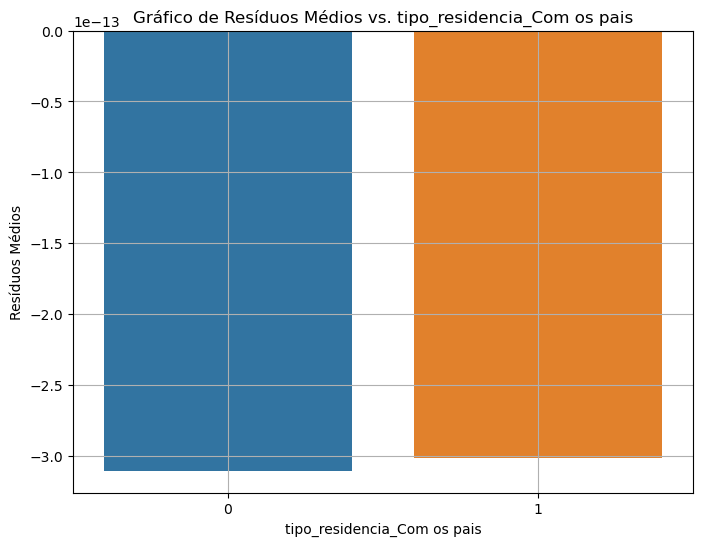

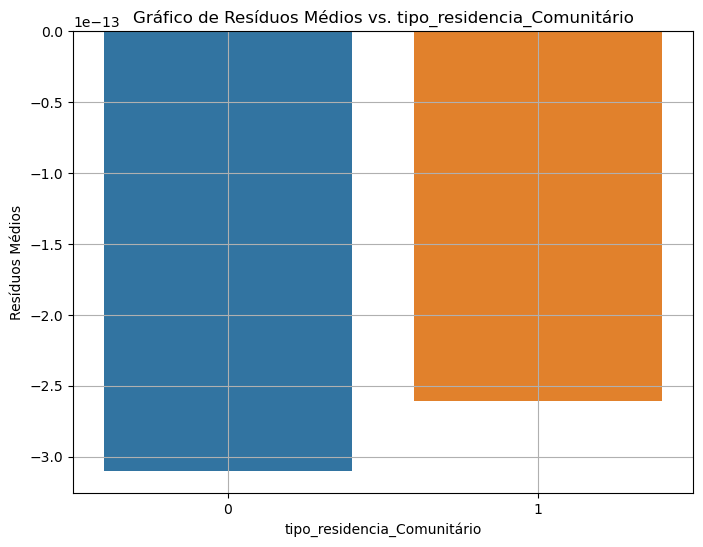

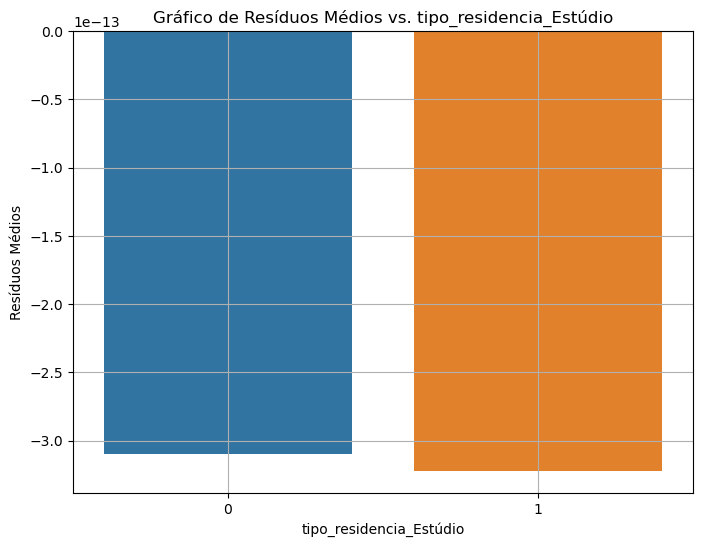

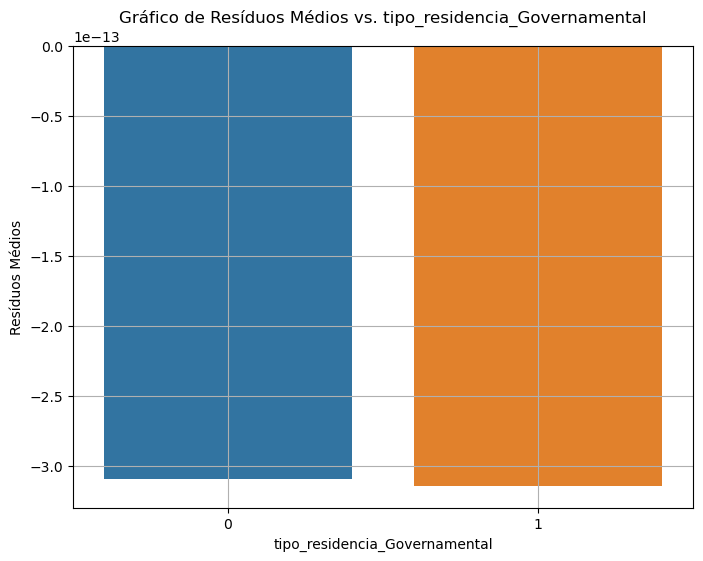

In [160]:
# Separando as colunas categóricas para aplicar o one-hot encoding apenas nessas variáveis
categoricas_encoded = df_treino.select_dtypes(include = ['uint8']).columns
categoricas_encoded

# Cria uma cópia para deixar melhor separado
df_treino_residuos = df_treino.copy()
# Adiciona a coluna de resíduos ao DataFrame df_treino_residuos
df_treino_residuos['residuos'] = residuos

for categoricas in categoricas_encoded:
    # Calcula a média dos resíduos para cada categoria da variável categórica
    media_residuos_por_categoria = df_treino_residuos.groupby(categoricas)['residuos'].mean().reset_index()

    # Plotar um gráfico de barras dos resíduos médios por categoria
    plt.figure(figsize=(8, 6))
    sns.barplot(x=categoricas, y='residuos', data=media_residuos_por_categoria)
    plt.xlabel(categoricas)
    plt.ylabel('Resíduos Médios')
    plt.title(f"Gráfico de Resíduos Médios vs. {categoricas}")
    plt.grid(True)
    plt.show()


### Valor médio dos resíduos por mês

In [161]:
# Adiciona a coluna de resíduos ao DataFrame df_treino_data
df_treino_data['residuos'] = residuos

# Cria uma nova coluna 'mes' contendo o mês de cada data
df_treino_data['mes'] = df_treino_data['data_ref'].dt.month

# Inicializa um dicionário para armazenar as médias dos resíduos por mês
media_residuos_por_mes = {}

# Itera sobre os meses únicos na coluna 'mes'
for mes in df_treino_data['mes'].unique():
    # Filtra o DataFrame para o mês atual
    df_mes_atual = df_treino_data[df_treino_data['mes'] == mes]
    # Calcula a média dos resíduos para o mês atual
    media_residuos_mes_atual = df_mes_atual['residuos'].mean()
    # Armazena a média dos resíduos para o mês atual no dicionário
    media_residuos_por_mes[mes] = media_residuos_mes_atual
    
# Converte o dicionário em um DataFrame
media_residuos_por_mes = pd.DataFrame.from_dict(media_residuos_por_mes, orient='index', columns=['media_residuos'])

# Ordena o DataFrame pela coluna do mês
media_residuos_por_mes = media_residuos_por_mes.sort_index()


#### O gráfico mostra uma oscilação dos residuos no inicio para o final do ano, com uma certa estabilidade entre abril e agosto, seria importante comparar com conjuntos de dados de outros anos para verificar se esse comportamente se repete, visto que esse conjunto de dados é de 2015 a 2016.

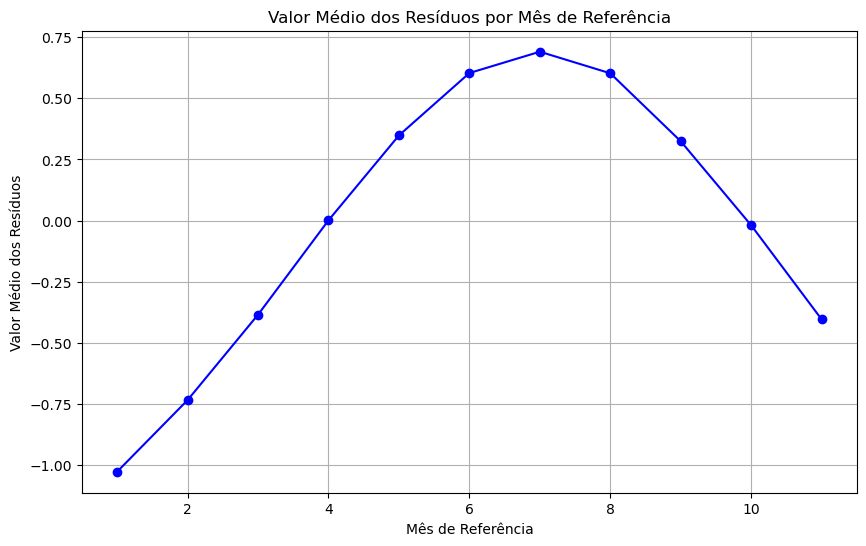

In [162]:
# Plotar um gráfico de linha dos valores médios dos resíduos por mês
plt.figure(figsize=(10, 6))
plt.plot(media_residuos_por_mes.index, media_residuos_por_mes['media_residuos'], marker='o', color='b', linestyle='-')
plt.xlabel('Mês de Referência')
plt.ylabel('Valor Médio dos Resíduos')
plt.title('Valor Médio dos Resíduos por Mês de Referência')
plt.grid(True)
plt.show()

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [163]:
# Calcula os resíduos studentizados a partir dos residuos salvo anteriormente
studentized_residuos = residuos / np.sqrt(reg_log.get_influence().resid_studentized_internal)

C:\Users\Bill_\AppData\Local\Temp\ipykernel_8760\2681923336.py:2: RuntimeWarning: invalid value encountered in sqrt
  studentized_residuos = residuos / np.sqrt(reg_log.get_influence().resid_studentized_internal)


In [164]:
# CARREGA ETERNAMENTE DEDVIDO AO VOLUME DE DADOS
'''fig = sm.graphics.influence_plot(reg_log, criterion = "cooks")
fig.tight_layout(pad=1.0)'''

'fig = sm.graphics.influence_plot(reg_log, criterion = "cooks")\nfig.tight_layout(pad=1.0)'

#### Simples Boxplot para bater o olho e já ter uma noção dos outliers, já da para perceber que os valores mais diferentes tendem a ser maiores que a média.

<Axes: >

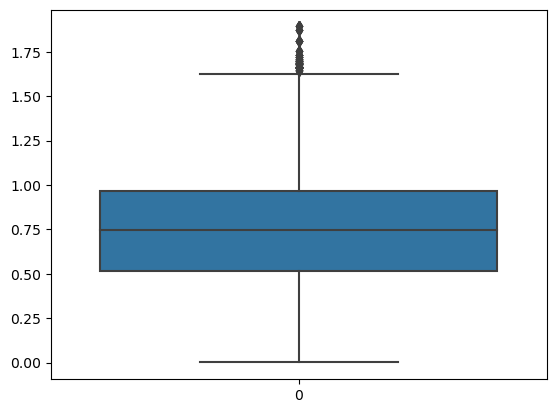

In [165]:
sns.boxplot(studentized_residuos)

#### Abaixo foi definido um limite para entender a que ponto estão concentrados os possíveis outliers, o limite foi sendo alterado até que fosse encontrado uma quantidade minima, sendo valores abaixo desse limite aumentam a quantidade de dados consideravelmente e acima desse valor não teria outliers considerados.

#### Obs: Os valores estão no formato studentized.

In [166]:
# Definindo um limite para os resíduos studentizados
limite = 1.8

# Identificando as observações que são outliers
outliers = np.abs(studentized_residuos) > limite

# Exibindo as observações que são outliers
print("Observações identificadas como outliers:")
print(np.where(outliers)[0])

Observações identificadas como outliers:
[220401 228569 243073 296720 319959 321090 334899 342138 344402 373200
 379795 390773 392640 396327 405801 415073 421890 436739 438026 444490]


#### Verificando qual o valor dos indices obtidos acima

In [167]:
valores_renda_outliers = y_treino[outliers]
print("Valores de renda correspondentes aos outliers:")
print(valores_renda_outliers)

Valores de renda correspondentes aos outliers:
220401    355734.02
228569    355734.02
243073    355734.02
296720    456669.31
319959    500207.23
321090    500207.23
334899    500207.23
342138    500207.23
344402    500207.23
373200    456669.31
379795    456669.31
390773    456669.31
392640    456669.31
396327    456669.31
405801    355734.02
415073    355734.02
421890    355734.02
436739    355734.02
438026    355734.02
444490    355734.02
Name: renda, dtype: float64


#### Em média os residuos está muito próximo de zero, porém existem valores negativos e positivos extremos de -3.9058 e 3.9584, isso indica que esses valores são quase 4x o desvio padrão dos residuos.

In [168]:
# Criando uma series do pandas com os residuos
serie_residuos = pd.Series(residuos)

# Calculando as estatísticas básicas dos resíduos
media_residuos = serie_residuos.mean()
maximo_residuos = serie_residuos.max()
minimo_residuos = serie_residuos.min()

# Exibir as estatísticas
print("Estatísticas básicas dos resíduos:")
print(f"Média: {media_residuos}")
print(f"Máximo: {maximo_residuos}")
print(f"Mínimo: {minimo_residuos}")

Estatísticas básicas dos resíduos:
Média: -3.0992881957817273e-13
Máximo: 3.958489051194414
Mínimo: -3.905892335602374


#### Salvando em residuos_significativos os indices e seus residuos que tem 2 vezes o valor do desvio padrão ou mais, esse valor é bem subjetivo e pode ser alterado.

In [169]:
residuos_significativos = []

for i, residuo in enumerate(serie_residuos):
    if residuo > 2 or residuo < -2:
        residuos_significativos.append((i, residuo))

# Exibir os índices e os resíduos que excedem o limite
print("Índices e resíduos que excedem o limite:")
for indice, residuo in residuos_significativos:
    print(f"Índice: {indice}, Resíduo: {residuo}")

Índices e resíduos que excedem o limite:
Índice: 21, Resíduo: -2.11653576442749
Índice: 32, Resíduo: -2.0592670793871353
Índice: 47, Resíduo: -2.3150686887938843
Índice: 63, Resíduo: -2.0832986501669613
Índice: 93, Resíduo: -2.0831404272948095
Índice: 116, Resíduo: -2.6575971844673534
Índice: 133, Resíduo: -2.2845628122810897
Índice: 140, Resíduo: -2.1487671451377217
Índice: 167, Resíduo: -2.512995825344424
Índice: 180, Resíduo: -2.137249353952077
Índice: 186, Resíduo: -3.0911769866354017
Índice: 188, Resíduo: -2.079515323512995
Índice: 199, Resíduo: -2.553195634254319
Índice: 205, Resíduo: -2.478486204847127
Índice: 211, Resíduo: -2.0805655078728593
Índice: 213, Resíduo: -2.5988167679734344
Índice: 217, Resíduo: -2.2121243410374998
Índice: 233, Resíduo: -2.0380985654438097
Índice: 242, Resíduo: -2.437129240521223
Índice: 304, Resíduo: -2.318534427335769
Índice: 305, Resíduo: -2.0206662380356377
Índice: 315, Resíduo: -2.107955437875037
Índice: 332, Resíduo: -2.157810363770812
Índice: 3

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

### Spearman

#### Primeiro foi separado as variáveis continuas para comparação, a correlação de spearman também trabalha com categórias, mas existe outros meios que trabalham melhor dessa maneira, dando resultados mais confiaveis com numéricas continuas.
<br>

#### De acordo com os resultados obtidos, não há uma correlação muito alta entre essas variáveis, sendo que nenhuma passou nem de 50% de correlação.

In [170]:
# Selecionando as variáveis continuas para comparar na correlação de spearman
continuas = ['qtd_filhos', 'idade', 'tempo_emprego']
spearman = df_treino[continuas].corr(method='spearman')
spearman

,qtd_filhos,idade,tempo_emprego
qtd_filhos,1.000000,-0.415284,-0.090340
idade,-0.415284,1.000000,0.301351
tempo_emprego,-0.090340,0.301351,1.000000


### VIF - Fator de Inflação da Variância

#### Abaixo foi usado o VIF para calcular o valor em relação a multicolineariedade de cada variável, sendo que 1 representa que não há uma correlação forte entre as demais variáveis, 6 a 10 existe uma correlação rasuável e acima de 10 já é um alerta de uma multicolinearidade.

In [171]:
vif_data = pd.DataFrame() # Criando DF para guardar os valores VIF
vif_data["Variavel"] = df_treino.columns # Criando coluna variável que e cada linha vai ser as variáveis(colunas do treino)
# Cria uma coluna VIF e salva os valores VIF ao percorrer o df_treino
vif_data["VIF"] = [variance_inflation_factor(df_treino.values, i) for i in range(df_treino.shape[1])]

vif_data

,Variavel,VIF
0,qtd_filhos,34.509581
1,idade,34.708451
2,tempo_emprego,3.021138
3,qt_pessoas_residencia,241.414115
4,sexo_M,1.822257
5,posse_de_veiculo_S,1.968046
6,posse_de_imovel_S,3.241482
7,tipo_renda_Bolsista,1.004068
8,tipo_renda_Empresário,1.477631
9,tipo_renda_Pensionista,2.196769


#### As variáveis qtd_filhos, idade, qt_pessoas_residencia, educacao_Médio, educacao_Superior completo, estado_civil_Solteiro e tipo_residencia_Casa têm valores de VIF significativamente altos, todos acima de 10. Isso indica multicolinearidade significativa entre essas variáveis e as outras variáveis independentes no modelo.
<br>

#### Será necessário fazer alterações na fase de ajustes como  remover variáveis altamente correlacionadas, combinar variáveis relacionadas em uma única variável, ou usar métodos de regularização durante a modelagem para mitigar os efeitos da multicolinearidade.

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.


### Outliers

#### Como a quantidade de linhas é gigante, é importante mostrar a quantidade de dados a ser considerados outliers e sua proporção quanto aos dados totais.

In [172]:
q_residuos_significativos = len(residuos_significativos)
q_residuos_significativos

proporcao_removidos = q_residuos_significativos / df_treino.shape[0]

print(f"Quantidade de removidos: {q_residuos_significativos}")
print(f"Proporção de removidos: {proporcao_removidos}")

Quantidade de removidos: 13735
Proporção de removidos: 0.02497272727272727


#### Aqui foi criado novos DataFrames(explicativo e resposta) sem os dados que são duas vezes ou mais que o valor de desvio padrão, um total de 2.5% dos dados foi ignorado para verificar o resultado final do modelo.

In [173]:
# Obtendo apenas os indices do residuos_significativos, o underline serve para ignorar os valores de
# residuo para que percorra apenas os indices.
indices_residuos_significativos = [indice for indice, _ in residuos_significativos]

# Removendo os valores que são 2x maiores que o desvio padrão e salvando nas novas variáveis
df_treino_sem_outliers = df_treino.drop(indices_residuos_significativos)
y_treino_log_sem_outliers = y_treino_log.drop(indices_residuos_significativos)

#### Em comparação  com o valor de R² do modelo anterior de 44.4, foi obtido um valor 4% melhor ao remover 2.5% dos dados. Levando em consideração que esses modelos já se encontram no formato logaritimico e a quantidade de dados removidos, é um aumento a se considerar.

In [174]:
# Criando o modelo de regressão com a variável de resposta em log
modelo_log_sem_outliers = sm.OLS(y_treino_log_sem_outliers, sm.add_constant(df_treino_sem_outliers))

# Ajustando o modelo aos dados
reg_log_sem_outliers = modelo_log_sem_outliers.fit()

# Calculando as previsões do modelo para os dados de treinamento
y_pred_log_sem_outliers = reg_log_sem_outliers.predict(sm.add_constant(df_treino_sem_outliers))


print(reg_log_sem_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 2.061e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:54:45   Log-Likelihood:            -6.6616e+05
No. Observations:              536265   AIC:                         1.332e+06
Df Residuals:                  536240   BIC:                         1.333e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Multicolinearidade

#### Nessa fase vai ser criado uma base de dados para trabalhar com a colinearidade, as colunas com maiores valores do VIF vão ser removidas até que estejam com valor 10 ou menor, a coluna removida e seu valor VIF serão salvos no dicionário max_vif_dic para poder entender seus impactos e poder fazer uma feature selection posteriormente.

In [175]:
# Copiando o vif_data anterior para usar essa variável no looping
vif_data_2 = vif_data.copy()

# Criando a base para trabalhar com colinearidade
df_treino_colinearidade = df_treino_sem_outliers
# Lista das variáveis que tiveram o maior fator de inflação da variância
max_vif_dic = {}

# Esse é o maior valor do que já havia sido calculado antes
max_vif = vif_data_2["VIF"].max()
# Essa é a coluna relacionada ao maior valor do VIF
variavel_max_vif = vif_data_2.loc[vif_data_2['VIF'] == max_vif, 'Variavel'].iloc[0]



# Looping para ficar com uma colinearidade igual ou abaixo de 10
while max_vif > 10:
    # Remove a coluna com o maior valor de VIF
    df_treino_colinearidade = df_treino_colinearidade.drop(variavel_max_vif, axis = 1)
    # Atualiza o dicionário, chave = coluna, valor = valor vif
    max_vif_dic[variavel_max_vif] = max_vif
    # Cria um Df, adiciona coluna Variavel que são as colunas e a coluna VIF que são os valores VIFs das colunas
    vif_data_2 = pd.DataFrame()
    vif_data_2["Variavel"] = df_treino_colinearidade.columns
    vif_data_2["VIF"] = [variance_inflation_factor(df_treino_colinearidade.values, i) for i in range(df_treino_colinearidade.shape[1])]
    # Atualiza o valor máximo de VIF em max_vif e sua respectiva coluna em variavel_max_vif
    max_vif = vif_data_2["VIF"].max()
    variavel_max_vif = vif_data_2.loc[vif_data_2['VIF'] == max_vif, 'Variavel'].iloc[0]

# Dicionário com coluna e valor do VIF
max_vif_dic


{'qt_pessoas_residencia': 241.41411464856333,
 'tipo_residencia_Casa': 43.32761990700374,
 'idade': 27.302598100431098}

### PCA

#### Na analise de componentes feita abaixo foi usado apenas as variáveis que tiveram um valor alto na veirificação do VIF, o qt_pessoas_residencia teve o melhor valor explicando 46% da variância.

In [176]:
dados_pca = df_treino[max_vif_dic.keys()] 

# Padronizar os dados
scaler = StandardScaler()
dados_pca_padronizados = scaler.fit_transform(dados_pca)

# Aplicar o PCA
pca = PCA()
componentes_principais = pca.fit_transform(dados_pca_padronizados)

# Variância explicada pelos componentes
variancia_explicada_ratio = pca.explained_variance_ratio_

for i, coluna in enumerate(max_vif_dic.keys()):
    print(f"{coluna}: {variancia_explicada_ratio[i]}")



qt_pessoas_residencia: 0.46045868902667003
tipo_residencia_Casa: 0.32948305629325886
idade: 0.21005825468007117


#### O modelo sem as 3 variáveis que tiveram um valor VIF alto não se alterou muito, mantendo quase o mesmo R².

In [177]:
# Criando o modelo de regressão com a variável de resposta em log
modelo_no_colinear = sm.OLS(y_treino_log_sem_outliers, sm.add_constant(df_treino_colinearidade))

# Ajustando o modelo aos dados
reg_no_colinear = modelo_no_colinear.fit()

# Calculando as previsões do modelo para os dados de treinamento
y_no_colinear = reg_no_colinear.predict(sm.add_constant(df_treino_colinearidade))


print(reg_no_colinear.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                 2.346e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:55:44   Log-Likelihood:            -6.6663e+05
No. Observations:              536265   AIC:                         1.333e+06
Df Residuals:                  536243   BIC:                         1.334e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### A regressão abaixo foi feita para verificar o impacto da variável qt_pessoas_residencia no resultado, então mesmo removendo apenas tipo_residencia_Casa, idade e deixando qt_pessoas_residencia, o resultado não alterou nem um pouco. Levando em consideração os problemas que a multicolinearidade podem trazer, o ideal seria deixar as 3 variáveis de fora do modelo.

In [178]:
colunas_coli_pca = ['tipo_residencia_Casa', 'idade']
df_treino_colinearidade_2 = df_treino_sem_outliers.drop(colunas_coli_pca, axis=1)

# Criando o modelo de regressão com a variável de resposta em log
modelo_no_colinear_2 = sm.OLS(y_treino_log_sem_outliers, sm.add_constant(df_treino_colinearidade_2))

# Ajustando o modelo aos dados
reg_no_colinear_2 = modelo_no_colinear_2.fit()

# Calculando as previsões do modelo para os dados de treinamento
y_no_colinear_2 = reg_no_colinear_2.predict(sm.add_constant(df_treino_colinearidade_2))


print(reg_no_colinear_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                 2.240e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:55:44   Log-Likelihood:            -6.6661e+05
No. Observations:              536265   AIC:                         1.333e+06
Df Residuals:                  536242   BIC:                         1.334e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Teste

#### Nessa parte esperava um R² menor, mas ainda que fizesse um pouco mais de sentido, tem algo de errado na utilização do modelo da base de treinamento aplicado na base de testes.

#### Foi removido as mesmas colunas que foram apontadas na etapa de verificação de multicolinearidade. Os outliers não foram removidos, entendo que seria uma etapa a ser feita apenas nos dados de treino.

In [209]:
# Copiando as bases originais
df_teste_modelado = df_teste.copy()
y_teste_log_modelado = y_teste_log.copy()

# Removendo as colunas que tiveram VIF acima do desejado (problema de multicolinearidade)
df_teste_modelado = df_teste_modelado.drop(max_vif_dic.keys(), axis = 1)

In [212]:
# Calcular as previsões do modelo para os dados de teste
pred_teste_modelado = reg_no_colinear.predict(sm.add_constant(df_teste_modelado))

# Calcular o R² ajustado para os dados de teste
r2_teste = r2_score(y_teste_log_modelado, pred_teste_modelado)
print("R² ajustado nos dados de teste:", r2_teste)

R² ajustado nos dados de teste: -0.526555058630289


#### Criei esse modelo apenas porque deu algo de errado na aplicação do modelo feito em treino para os dados de teste.

In [206]:
# Criando o modelo de regressão com a variável de resposta em log
modelo_teste = sm.OLS(y_teste_log_modelado, sm.add_constant(df_teste_modelado))

# Ajustando o modelo aos dados
reg_teste = modelo_teste.fit()

# Calculando as previsões do modelo para os dados de treinamento
pred_teste = reg_teste.predict(sm.add_constant(df_teste_modelado))


print(reg_teste.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                 1.059e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:43:15   Log-Likelihood:            -2.2957e+05
No. Observations:              200000   AIC:                         4.592e+05
Df Residuals:                  199978   BIC:                         4.594e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Extra
<br>

#### Apenas para fins ded comparação, peguei o modelo mais simples e removi os valores extremos enquanto se calcula o R² ao longo das remoções para poder comparar.

#### Feito um teste de R² vs Remoção dos valores máximos, como apenas valores acima da média estão como outliers no Boxplot, foi removido o valor máximo e calculado um novo R² e comparado se esse novo valor é melhor do que o anterior (com o valor máximo) mais um valor de significancia, então esse processo se repete até que a melhora do R² é tão pequena que não supera o valor de significancia.

#### Disclaimer: O R² vai aumentar normalmente e o ideal não é apenas se basear nesse indicador, mas analisar o quanto ele melhora ao tirar valores extremos, se é significante ou não.

In [ ]:
r_squared = reg.rsquared
r_squared_atual = r_squared
significancia = 0.0001
df_treino_total_looping = df_treino_total.copy()
q_removido = 1

while r_squared <= r_squared_atual:
    
    r_squared = r_squared_atual    
        
    # Encontra o valor máximo da coluna de renda
    valor_maximo_renda = df_treino_total_looping['renda'].max()
    # Remova as linhas onde a renda é igual ao valor máximo
    dados_filtrados = df_treino_total_looping[df_treino_total_looping['renda'] < valor_maximo_renda]
    
    ############################################
    # Separando para fazer o modelo
    X = dados_filtrados.drop(columns=['renda'])
    y = dados_filtrados['renda']
    # Criado o modelo de regressão
    modelo = sm.OLS(y, sm.add_constant(X))

    # Ajuste do modelo aos dados
    modelo_fitted = modelo.fit()
    
    # Salvando o R²
    r_squared_atual = modelo_fitted.rsquared
    #############################################
    
    # Atualiza o df para não ter os valores extremos do máximo
    df_treino_total_looping = dados_filtrados
    
    # Adicionando valor de significancia
    r_squared += significancia
    
    
    print(f"{q_removido} máximo removido")
    q_removido += 1
    print(f"anterior:{r_squared} vs novo:{r_squared_atual}")
    print("\n")
    